## Plotting Notebook
#### for visalizing binned prevalence of malaria from hm sims and cuts

## Import Block

In [1]:
import itertools
import os, re
import sqlite3
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.special import gammaln

from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

## Specify experiment to analyze

In [2]:
exp_id  = '85f915dc-8c01-ea11-a2c3-c4346bcb1551'
# exp_id = 'a66710a9-b601-ea11-a2c3-c4346bcb1551'

## Load in experiment analyzer_results

In [3]:
results_df = pd.read_csv(os.path.join(exp_id,'analyzer_results.csv'))
results_df.rename(columns ={'age_bin':'Age Bin','density_bin': 'PfPR Bin','season':'Season','value':'sim_proportion'},inplace=True)


## Read reference data

In [4]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [5]:
df = pd.read_csv(os.path.join('..','reference data','Garki_df.csv'))
self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, 2000000],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [1, 4, 8, 18, 28, 43, 125],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

ref_df =dftemp.copy(deep = True)
ref_df['bin_pop'] = ref_df.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_df['proportion'] = ref_df['Counts'] / ref_df['bin_pop']
ref_df.reset_index(inplace=True)
ref_df = ref_df[ref_df.Channel == 'PfPR by Parasitemia and Age Bin'].drop(columns = ['Channel'])
print(ref_df.head())


    Season Age Bin  PfPR Bin  Counts  bin_pop  proportion
105    DC2       1         0    17.0     49.0    0.346939
106    DC2       1        50     6.0     49.0    0.122449
107    DC2       1       200     7.0     49.0    0.142857
108    DC2       1       500     5.0     49.0    0.102041
109    DC2       1   2000000    14.0     49.0    0.285714


c:\venv\malaria-ug-icemr\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


## Compare sim and ref df

In [6]:
# print(results_df.head())
# print(ref_df.head())
ref_df['Age Bin'] = ref_df['Age Bin'].astype(int)


merged_df = ref_df.merge(results_df)
# merged_df.sort_values(by= ['sim_id'],inplace = True)
print(merged_df.head(10))

  Season  Age Bin  PfPR Bin  Counts  bin_pop  proportion  Unnamed: 0  sample  \
0    DC2        1         0    17.0     49.0    0.346939           0       1   
1    DC2        1         0    17.0     49.0    0.346939           0       9   
2    DC2        1         0    17.0     49.0    0.346939           0      10   
3    DC2        1         0    17.0     49.0    0.346939           0       5   
4    DC2        1         0    17.0     49.0    0.346939           0      16   
5    DC2        1         0    17.0     49.0    0.346939           0      14   
6    DC2        1         0    17.0     49.0    0.346939           0      42   
7    DC2        1         0    17.0     49.0    0.346939           0      22   
8    DC2        1         0    17.0     49.0    0.346939           0      46   
9    DC2        1         0    17.0     49.0    0.346939           0      28   

                                 sim_id  sim_proportion  
0  212232e2-8c01-ea11-a2c3-c4346bcb1551        0.758249  
1  

c:\venv\malaria-ug-icemr\lib\site-packages\pandas\core\reshape\merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
c:\venv\malaria-ug-icemr\lib\site-packages\pandas\core\reshape\merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


## Plot

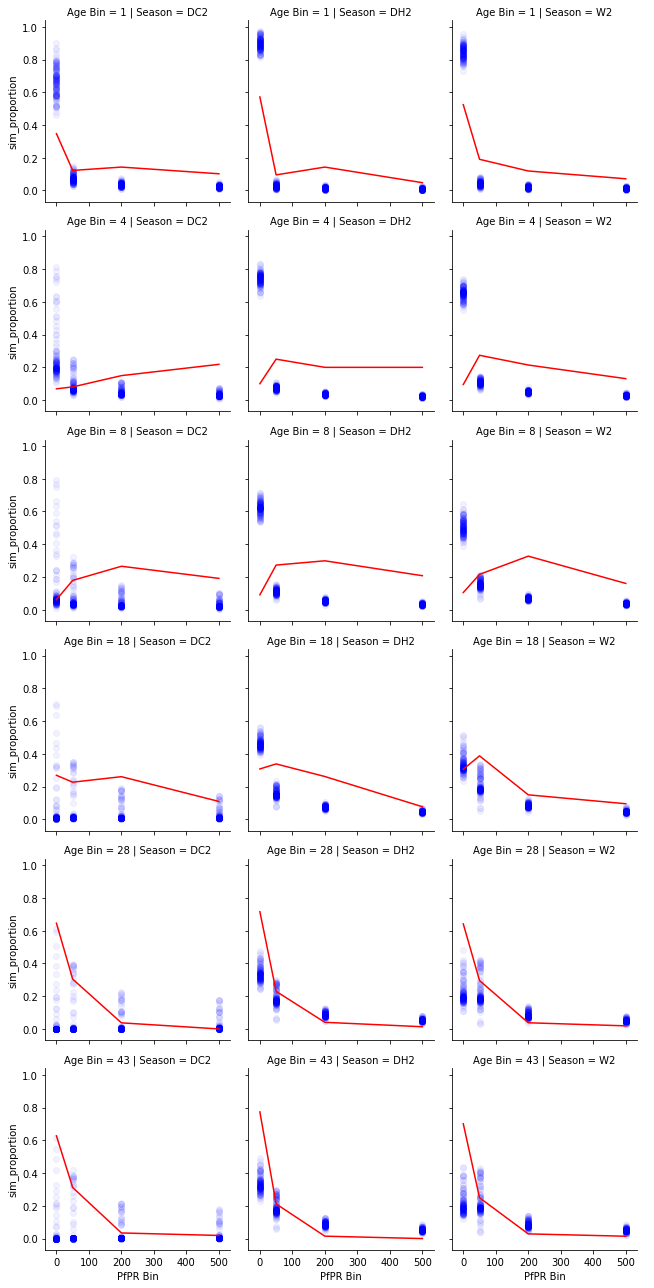

In [7]:
g = sns.FacetGrid(merged_df, col='Season', row='Age Bin')
g = g.map(plt.plot, "PfPR Bin", "proportion", color='r')
g = g.map(plt.scatter, "PfPR Bin", "sim_proportion", alpha = 0.05, color='b')
g.add_legend()